###  Data Scraping, Cleaning & Wrangling
- [1.1 Overview](#1_1)
- [1.2 Loading and Imports](#1_2)
- [1.3 Data Fetching, API, and Reshaping](#1_3)
- [1.4 Zipcode Inspection](#1_4)
- [1.5 Exporting](#1_5)

### 1.1 Overview <a id = "1_1"></a>
- The goal of this is to get a sense of what data we're working with and prepare it for exploratory data analysis
- On the general level, we want to see how we can optimize the pricing of listings for hosts (and give them ideal prices to give based on particular attributes)

We I will be considering will be listing data found here (https://insideairbnb.com/get-the-data/):
  - Number of rooms
  - Amenities (gym, pool, etc)
  - Neighborhood attributes

We will also be using the zipcodes found in listing info to pull from US Census Data (via Census API) to attribute information on:
  - Neighborhood Conditions
  - Income and Rent
  - Demographics
  - Transportation data
  - Education
  - and much more to see if other data has an effect on AirBnB listing prices

To get an accurate representation of the demographic data of each neighborhood, we will use longitude and latitude data in listings table to fetch their zip code (via geopy)
- We will fetch the zip codes for each row in listings, and another table with all unique zipcodes and their census table. We will then merge from there.

### 1.2 Loading and Imports <a id = "1_2"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
df_listing = pd.read_csv('NYC_listings.csv')
df_listing.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,739333866230665371,https://www.airbnb.com/rooms/739333866230665371,20240904164109,2024-09-04,city scrape,Lovely room 2 windows tv work desk ac included,"Lovely vocation room, has work desk , tv, 2 wi...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,3013025,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
1,572612125615500056,https://www.airbnb.com/rooms/572612125615500056,20240904164109,2024-09-04,city scrape,Room by Sunny & Bay! Sunset Park & Bay Ridge,Cozy room in a charming Sunset Park apartment....,NaN,https://a0.muscache.com/pictures/5f44a178-6043...,358089614,...,4.83,4.67,4.67,NaN,t,2,0,2,0,0.21
2,45267941,https://www.airbnb.com/rooms/45267941,20240904164109,2024-09-04,city scrape,Private Room in Luxury Apartment,NaN,NaN,https://a0.muscache.com/pictures/3c15a88e-b08a...,39162543,...,NaN,NaN,NaN,NaN,f,3,2,1,0,NaN


#### We will be using geopy to locate zip codes of long/lat data of each listing
- From there, we will use the Census API to collect information with the associated zipcode

In [9]:
!pip install geopy

In [12]:
# Below is test examples of lat and lon, we will run this through our data after we reshape it

import geopy

def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']
geolocator = geopy.Nominatim(user_agent='airBnB_data_research')

df = pd.DataFrame({
    'Lat': [29.39291, 29.39923, 29.40147, 29.38752, 29.39291, 29.39537, 29.39343, 29.39291, 29.39556],
    'Lon': [-98.50925, -98.51256, -98.51123, -98.52372, -98.50925, -98.50402, -98.49707, -98.50925, -98.53148]
})
zipcodes = df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')

In [74]:
zipcodes

0    78204
1    78204
2    78204
3    78225
4    78204
5    78204
6    78204
7    78204
8    78225
dtype: object

In [14]:
# let's find the relevant zipcode data after we clean out our dataframe ro reduce amount of data we need to process Zipcodes for

### 1.3 Data Exploration and Reshaping <a id = "1_3"></a>

In [15]:
# There's 75 columns, we don't need every column obviously so lets see what was can drop
df_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [16]:
columns_to_keep = [
    'neighbourhood_cleansed', 'price', 'latitude', 'longitude',
    'room_type', 'property_type', 'accommodates', 'bedrooms', 'beds', 
    'bathrooms', 'bathrooms_text', 'amenities','review_scores_rating', 'review_scores_cleanliness', 
    'review_scores_location', 'review_scores_value', 
    'host_is_superhost', 'neighbourhood_group_cleansed', 
    'calculated_host_listings_count'  , 'neighborhood_overview', 
]

# 'number_of_reviews', 'reviews_per_month', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'minimum_nights', 'maximum_nights'
# 'host_listings_count', 'description' #contains text about location

df_listing = df_listing[columns_to_keep]
df_listing.head(3)

,neighbourhood_cleansed,price,latitude,longitude,room_type,property_type,accommodates,bedrooms,beds,bathrooms,bathrooms_text,amenities,review_scores_rating,review_scores_cleanliness,review_scores_location,review_scores_value,host_is_superhost,neighbourhood_group_cleansed,calculated_host_listings_count,neighborhood_overview
0,Fort Hamilton,$89.00,40.61431,-74.03444,Private room,Private room in rental unit,1,1.0,1.0,1.0,1 shared bath,"[""Kitchen"", ""Dedicated workspace"", ""TV"", ""Smok...",NaN,NaN,NaN,NaN,f,Brooklyn,1,NaN
1,Sunset Park,$45.00,40.63952,-74.01484,Private room,Private room in rental unit,1,1.0,1.0,1.0,1 shared bath,"[""Single level home"", ""Cleaning products"", ""St...",4.83,4.67,4.67,4.67,t,Brooklyn,2,NaN
2,Morris Heights,$107.00,40.85003,-73.92281,Private room,Private room in rental unit,2,1.0,1.0,1.0,1 shared bath,"[""Kitchen"", ""Hair dryer"", ""Hot water"", ""Dryer""...",NaN,NaN,NaN,NaN,f,Bronx,3,NaN


In [17]:
#check what percetnage of values are null values
(df_listing.isna().sum()/df_listing.shape[0])  * 100

neighbourhood_cleansed             0.000000
price                             39.293040
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
property_type                      0.000000
accommodates                       0.000000
bedrooms                          15.558989
beds                              39.652646
bathrooms                         39.293040
bathrooms_text                     0.085240
amenities                          0.000000
review_scores_rating              30.739725
review_scores_cleanliness         30.742388
review_scores_location            30.787672
review_scores_value               30.785008
host_is_superhost                  1.142751
neighbourhood_group_cleansed       0.000000
calculated_host_listings_count     0.000000
neighborhood_overview             44.351509
dtype: float64

Based on the missing null values, I'm concerned about:
- Our predictor variables price is missing in 40% of the data, and reviews is 30% of our data
- Missing bed and bathrooms data
- We will drop our null in price variables and see if it's nulls shared throughout multiple columns

In [18]:
df_listing.dropna(subset='price', inplace=True)

In [19]:
df_listing.shape

(22790, 20)

In [20]:
(df_listing.isna().sum()/df_listing.shape[0])  * 100

neighbourhood_cleansed             0.000000
price                              0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
property_type                      0.000000
accommodates                       0.000000
bedrooms                           0.210619
beds                               0.618692
bathrooms                          0.026327
bathrooms_text                     0.074594
amenities                          0.000000
review_scores_rating              29.346204
review_scores_cleanliness         29.346204
review_scores_location            29.350592
review_scores_value               29.346204
host_is_superhost                  1.597192
neighbourhood_group_cleansed       0.000000
calculated_host_listings_count     0.000000
neighborhood_overview             43.865731
dtype: float64

In [21]:
# take note, neighborhood_overview is still over 43%, reviews around 30%
# Let's drop these column  
# df_listing.columns
df_listing = df_listing.drop(columns=['neighborhood_overview', 'review_scores_rating', 
                      'review_scores_cleanliness', 'review_scores_location', 
                      'review_scores_value'])

In [22]:
df_listing.head(3)
(df_listing.isna().sum()/df_listing.shape[0])  * 100

neighbourhood_cleansed            0.000000
price                             0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
property_type                     0.000000
accommodates                      0.000000
bedrooms                          0.210619
beds                              0.618692
bathrooms                         0.026327
bathrooms_text                    0.074594
amenities                         0.000000
host_is_superhost                 1.597192
neighbourhood_group_cleansed      0.000000
calculated_host_listings_count    0.000000
dtype: float64

##### We have the columns we want to check for now, let's begin extracting zipcodes

In [ ]:
# Function to get ZIP code for a given latitude and longitude
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from tqdm import tqdm         #library to check how long function will run for

def get_zipcode(row):
    try:
        # Reverse geocoding to get location details
        location = geolocator.reverse((row['latitude'], row['longitude']), timeout=10)
        if location and 'postcode' in location.raw['address']:
            return location.raw['address']['postcode']
    except GeocoderTimedOut:
        # Retry once if timeout occurs
        time.sleep(1)
        return get_zipcode(row)
    except Exception as e:
        print(f"Error for {row['latitude']}, {row['longitude']}: {e}")
    return None

In [ ]:
trial = df_listing.head(10)
trial['zip_code'] = trial.apply(get_zipcode, axis=1)
trial

C:\Users\Andre\AppData\Local\Temp\ipykernel_14580\3690169691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial['zip_code'] = trial.apply(get_zipcode, axis=1)


,neighbourhood_cleansed,price,latitude,longitude,room_type,property_type,accommodates,bedrooms,beds,bathrooms,bathrooms_text,amenities,host_is_superhost,neighbourhood_group_cleansed,calculated_host_listings_count,zip_code
0,Fort Hamilton,$89.00,40.614310,-74.034440,Private room,Private room in rental unit,1,1.0,1.0,1.0,1 shared bath,"[""Kitchen"", ""Dedicated workspace"", ""TV"", ""Smok...",f,Brooklyn,1,11209
1,Sunset Park,$45.00,40.639520,-74.014840,Private room,Private room in rental unit,1,1.0,1.0,1.0,1 shared bath,"[""Single level home"", ""Cleaning products"", ""St...",t,Brooklyn,2,11220
2,Morris Heights,$107.00,40.850030,-73.922810,Private room,Private room in rental unit,2,1.0,1.0,1.0,1 shared bath,"[""Kitchen"", ""Hair dryer"", ""Hot water"", ""Dryer""...",f,Bronx,3,10040
3,East Harlem,$140.00,40.798718,-73.940093,Entire home/apt,Entire rental unit,8,3.0,3.0,2.0,2 baths,"[""Building staff"", ""Elevator"", ""Dedicated work...",f,Manhattan,5,10035
4,South Slope,$340.00,40.668012,-73.985226,Entire home/apt,Entire home,5,4.0,4.0,2.5,2.5 baths,"[""BBQ grill"", ""Kitchen"", ""Dedicated workspace""...",f,Brooklyn,3,11215
5,Brownsville,$54.00,40.664178,-73.911589,Private room,Private room in rental unit,2,1.0,1.0,1.0,1 private bath,[],f,Brooklyn,1,11212
6,Bedford-Stuyvesant,$47.00,40.678946,-73.943759,Private room,Private room in rental unit,2,1.0,1.0,1.0,1 bath,"[""Kitchen"", ""Smoke alarm"", ""Washer"", ""Carbon m...",f,Brooklyn,24,11216
7,Sunnyside,$280.00,40.741837,-73.926836,Entire home/apt,Entire rental unit,4,2.0,3.0,1.0,1 bath,"[""Kitchen"", ""Fire extinguisher"", ""TV"", ""Smoke ...",f,Queens,3,11101
8,Bedford-Stuyvesant,$60.00,40.682750,-73.958140,Entire home/apt,Entire rental unit,2,1.0,1.0,1.0,1 bath,"[""Kitchen"", ""Smoke alarm"", ""Hangers"", ""Carbon ...",f,Brooklyn,1,11238
9,East Village,$180.00,40.725692,-73.983761,Entire home/apt,Entire rental unit,3,2.0,1.0,1.0,1 bath,"[""Kitchen"", ""Dedicated workspace"", ""Smoke alar...",f,Manhattan,3,10009


In [25]:
tqdm.pandas() #time track

df_listing['zip_code'] = df_listing.progress_apply(get_zipcode, axis=1)

df_listing.to_csv('df_listing_with_zip_codes.csv', index=False)

print(df_listing.head())

  0%|          | 0/22790 [00:00<?, ?it/s]

100%|██████████| 22790/22790 [3:43:03<00:00,  1.70it/s]   


  neighbourhood_cleansed    price   latitude  longitude        room_type  \
0          Fort Hamilton   $89.00  40.614310 -74.034440     Private room   
1            Sunset Park   $45.00  40.639520 -74.014840     Private room   
2         Morris Heights  $107.00  40.850030 -73.922810     Private room   
3            East Harlem  $140.00  40.798718 -73.940093  Entire home/apt   
4            South Slope  $340.00  40.668012 -73.985226  Entire home/apt   

                 property_type  accommodates  bedrooms  beds  bathrooms  \
0  Private room in rental unit             1       1.0   1.0        1.0   
1  Private room in rental unit             1       1.0   1.0        1.0   
2  Private room in rental unit             2       1.0   1.0        1.0   
3           Entire rental unit             8       3.0   3.0        2.0   
4                  Entire home             5       4.0   4.0        2.5   

  bathrooms_text                                          amenities  \
0  1 shared bath  ["K

*note 6 hour runtime to run all zip code api

In [26]:
df_listing.head(5)

,neighbourhood_cleansed,price,latitude,longitude,room_type,property_type,accommodates,bedrooms,beds,bathrooms,bathrooms_text,amenities,host_is_superhost,neighbourhood_group_cleansed,calculated_host_listings_count,zip_code
0,Fort Hamilton,$89.00,40.614310,-74.034440,Private room,Private room in rental unit,1,1.0,1.0,1.0,1 shared bath,"[""Kitchen"", ""Dedicated workspace"", ""TV"", ""Smok...",f,Brooklyn,1,11209
1,Sunset Park,$45.00,40.639520,-74.014840,Private room,Private room in rental unit,1,1.0,1.0,1.0,1 shared bath,"[""Single level home"", ""Cleaning products"", ""St...",t,Brooklyn,2,11220
2,Morris Heights,$107.00,40.850030,-73.922810,Private room,Private room in rental unit,2,1.0,1.0,1.0,1 shared bath,"[""Kitchen"", ""Hair dryer"", ""Hot water"", ""Dryer""...",f,Bronx,3,10040
3,East Harlem,$140.00,40.798718,-73.940093,Entire home/apt,Entire rental unit,8,3.0,3.0,2.0,2 baths,"[""Building staff"", ""Elevator"", ""Dedicated work...",f,Manhattan,5,10035
4,South Slope,$340.00,40.668012,-73.985226,Entire home/apt,Entire home,5,4.0,4.0,2.5,2.5 baths,"[""BBQ grill"", ""Kitchen"", ""Dedicated workspace""...",f,Brooklyn,3,11215


In [51]:
!pip install census

  Using cached census-0.8.22-py3-none-any.whl.metadata (8.1 kB)
Using cached census-0.8.22-py3-none-any.whl (11 kB)


In [ ]:
#We fetch the unique zipcodes from the df so we don't have to run through all 20000 rows again. Then we merge
unique_zip_codes = df_listing['zip_code'].dropna().unique()
len(unique_zip_codes)

216

In [ ]:
from census import Census

census_api_key = "58ccb8e9c501bfdb5dd81ba150ba1225e7904658"
c = Census(census_api_key)

variables = [
    'B01003_001E',  # Total Population
    'B19013_001E',  # Median Household Income
    'B25064_001E',  # Median Gross Rent
    'B25077_001E',  # Median Home Value
    'B25002_003E',  # Vacant Housing Units
    'B25002_001E',  # Total Housing Units
    'B08303_001E',  # Travel Time to Work
    'B01002_001E',  # Median Age
    'B03002_012E',  # Non-Hispanic White Population
    'B03002_003E',  # Hispanic or Latino Population
    'B19301_001E',  # Per Capita Income
    'B17001_002E',  # Poverty Count
    'B25034_001E',  # Median Year Built
    'B25070_007E',  # Rent 30-50% of Income
    'B25001_001E',  # Total Housing Units
    'B15003_017E',  # Bachelor’s Degree Attainment
    'B08134_001E',  # Workers Using Public Transit
    'B08201_001E',  # Vehicles Available
]

def fetch_census_data(zip_codes):
    census_data = []
    
    for zip_code in tqdm(zip_codes, desc="Fetching Census Data"):
        try:
            data = c.acs5.get(
                variables,
                {'for': f'zip code tabulation area:{zip_code}'}
            )
            if data:
                census_data.append(data[0])
            time.sleep(1)  # Rate limiting
        except Exception as e:
            print(f"Error fetching data for ZIP {zip_code}: {e}")
    
    # Convert results to DataFrame
    return pd.DataFrame(census_data)

In [57]:
# Fetch Census data
census_data = fetch_census_data(unique_zip_codes)

Fetching Census Data: 100%|██████████| 216/216 [06:01<00:00,  1.67s/it]


In [70]:
#rename variables

rename_mapping = {
    'B01003_001E': 'total_population',
    'B19013_001E': 'median_income',
    'B25064_001E': 'median_rent',
    'B25077_001E': 'median_home_value',
    'B25002_003E': 'vacant_units',
    'B25002_001E': 'total_units',
    'B08303_001E': 'avg_commute_time',
    'B01002_001E': 'median_age',
    'B03002_012E': 'non_hispanic_white',
    'B03002_003E': 'hispanic_population',
    'B19301_001E': 'per_capita_income',
    'B17001_002E': 'poverty_count',
    'B25034_001E': 'median_year_built',
    'B25070_007E': 'rent_burden_30_50',
    'B25001_001E': 'total_housing_units',
    'B15003_017E': 'bachelors_degree',
    'B08134_001E': 'workers_public_transit',
    'B08201_001E': 'vehicles_available',
    'zip code tabulation area': 'zip_code'
}

census_data.rename(columns=rename_mapping, inplace=True)

census_data.head(5)

,total_population,median_income,median_rent,median_home_value,vacant_units,total_units,avg_commute_time,median_age,non_hispanic_white,hispanic_population,per_capita_income,poverty_count,median_year_built,rent_burden_30_50,total_housing_units,bachelors_degree,workers_public_transit,vehicles_available,zip_code
0,71812.0,88546.0,1801.0,935000.0,3168.0,33347.0,28537.0,40.6,14178.0,43362.0,52048.0,7636.0,33347.0,1605.0,33347.0,7960.0,28537.0,30179.0,11209
1,93008.0,62804.0,1641.0,978800.0,2658.0,30565.0,36683.0,36.0,38012.0,13974.0,25708.0,20513.0,30565.0,1677.0,30565.0,14065.0,36683.0,27907.0,11220
2,43653.0,59115.0,1623.0,454000.0,889.0,17430.0,17098.0,40.3,31339.0,8924.0,35363.0,7806.0,17430.0,824.0,17430.0,5462.0,17098.0,16541.0,10040
3,38595.0,36989.0,1116.0,661800.0,1406.0,16239.0,12539.0,37.1,16604.0,5033.0,30083.0,13268.0,16239.0,1612.0,16239.0,5340.0,12539.0,14833.0,10035
4,72014.0,173899.0,2673.0,1597400.0,2502.0,31967.0,29437.0,37.2,10855.0,48203.0,98246.0,4189.0,31967.0,1382.0,31967.0,2872.0,29437.0,29465.0,11215


#### 1.4 Zipcodes <a id = "1_4"></a>
- Are there enough datapoints for each zipcode?

In [61]:
# number of neighborhood
df_listing.zip_code.nunique()

216

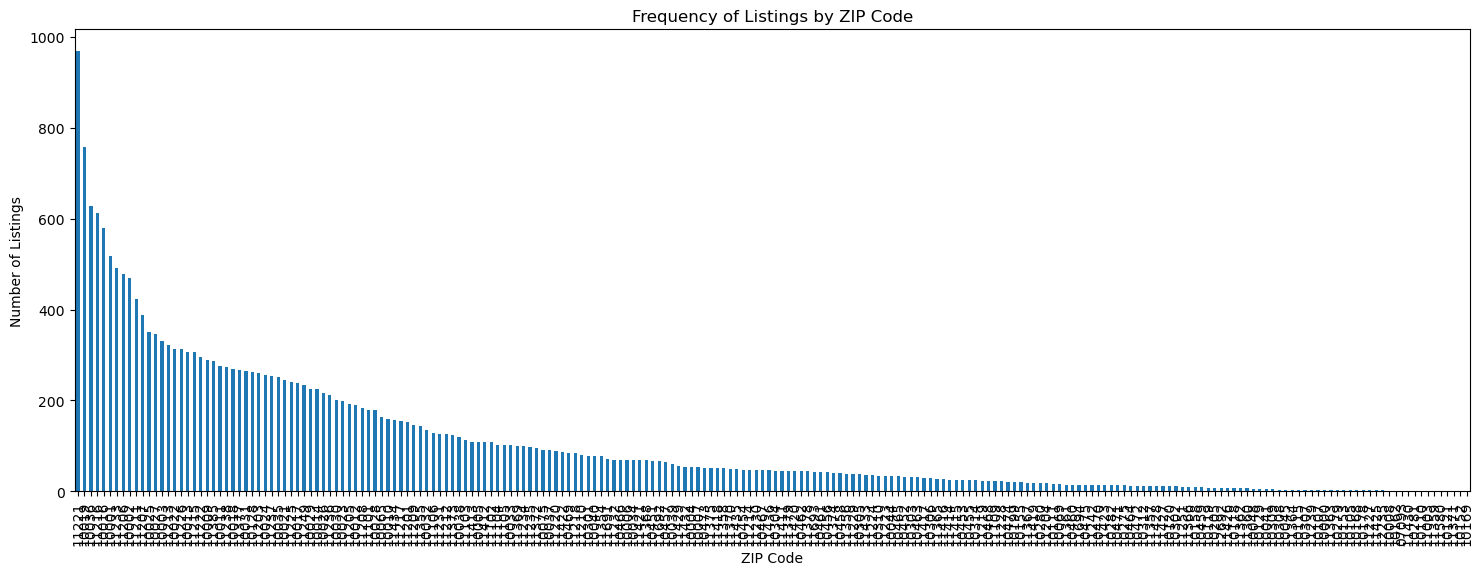

In [68]:
zip_code_counts = df_listing['zip_code'].value_counts()

plt.figure(figsize=(18, 6))
zip_code_counts.plot(kind='bar')
plt.title("Frequency of Listings by ZIP Code")
plt.xlabel("ZIP Code")
plt.ylabel("Number of Listings")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

In [72]:
# we will consider dropping a few of these zip codes with extremeley low frequencies. 
# But for the most part it looks like there is a sizeable amount of listings for majority of our zipcodes

### 1.5 Exporting  <a id = "1_5"></a>
- we will export our cleaned data frame for our listings and for our census data, and then we will work from there

In [75]:
# exporting census data
pd.DataFrame(census_data).to_csv('NY_census_demographics.csv', index=False)